In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import seaborn as sns


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Read Data
df_mkpf = pd.read_excel('../Data1/MKPF.XLSX')

In [4]:
df_mkpf.head(4)

,MBLNR,MJAHR,VGART,BLART,BLAUM,BLDAT,BUDAT,CPUDT,CPUTM,AEDAT,USNAM,TCODE,XBLNR,BKTXT,FRATH,FRBNR,WEVER,XABLN,AWSYS,BLA2D,TCODE2,BFWMS,EXNUM,SPE_BUDAT_UHR,SPE_BUDAT_ZONE,LE_VBELN,SPE_LOGSYS,SPE_MDNUM_EWM,GTS_CUSREF_NO,FLS_RSTO,MSR_ACTIVE,KNUMV
0,4900000000,2021,WR,WA,PR,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,ADMIN1,NaN,NaN,NaN,0,NaN,NaN,NaN,I20CLNT934,NaN,COGI,NaN,NaN,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4900000001,2021,WR,WA,PR,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,ADMIN1,NaN,NaN,NaN,0,NaN,NaN,NaN,I20CLNT934,NaN,COGI,NaN,NaN,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4900000002,2021,WR,WA,PR,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,ADMIN1,NaN,NaN,NaN,0,NaN,NaN,NaN,I20CLNT934,NaN,COGI,NaN,NaN,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4900000003,2021,WR,WA,PR,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,ADMIN1,NaN,NaN,NaN,0,NaN,NaN,NaN,I20CLNT934,NaN,COGI,NaN,NaN,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_mseg = pd.read_excel('../Data1/MSEG.XLSX')

In [6]:
df_mseg.head(4)

,MBLNR,MJAHR,ZEILE,LINE_ID,PARENT_ID,LINE_DEPTH,MAA_URZEI,BWART,XAUTO,MATNR,WERKS,LGORT,CHARG,INSMK,ZUSCH,ZUSTD,SOBKZ,LIFNR,KUNNR,KDAUF,KDPOS,KDEIN,PLPLA,SHKZG,WAERS,DMBTR,BNBTR,BUALT,SHKUM,DMBUM,BWTAR,MENGE,MEINS,ERFMG,ERFME,BPMNG,BPRME,EBELN,EBELP,LFBJA,LFBNR,LFPOS,SJAHR,SMBLN,SMBLP,ELIKZ,SGTXT,EQUNR,WEMPF,ABLAD,GSBER,KOKRS,PARGB,PARBU,KOSTL,PROJN,AUFNR,ANLN1,ANLN2,XSKST,XSAUF,XSPRO,XSERG,GJAHR,XRUEM,XRUEJ,BUKRS,BELNR,BUZEI,BELUM,BUZUM,RSNUM,RSPOS,KZEAR,PBAMG,KZSTR,UMMAT,UMWRK,UMLGO,UMCHA,UMZST,UMZUS,UMBAR,UMSOK,KZBEW,KZVBR,KZZUG,WEUNB,PALAN,LGNUM,LGTYP,LGPLA,BESTQ,BWLVS,TBNUM,TBPOS,XBLVS,VSCHN,NSCHN,DYPLA,UBNUM,TBPRI,TANUM,WEANZ,GRUND,EVERS,EVERE,IMKEY,KSTRG,PAOBJNR,PRCTR,PS_PSP_PNR,NPLNR,AUFPL,APLZL,AUFPS,VPTNR,FIPOS,SAKTO,BSTMG,BSTME,XWSBR,EMLIF,EXBWR,VKWRT,AKTNR,ZEKKN,VFDAT,CUOBJ_CH,EXVKW,PPRCTR,RSART,GEBER,FISTL,MATBF,UMMAB,BUSTM,BUSTW,MENGU,WERTU,LBKUM,SALK3,VPRSV,FKBER,DABRBZ,VKWRA,DABRZ,XBEAU,LSMNG,LSMEH,KZBWS,QINSPST,URZEI,J_1BEXBASE,MWSKZ,TXJCD,EMATN,J_1AGIRUPD,VKMWS,HSDAT,BERKZ,MAT_KDAUF,MAT_KDPOS,MAT_PSPNR,XWOFF,BEMOT,PRZNR,LLIEF,LSTAR,XOBEW,GRANT_NBR,ZUSTD_T156M,SPE_GTS_STOCK_TY,KBLNR,KBLPOS,XMACC,VGART_MKPF,BUDAT_MKPF,CPUDT_MKPF,CPUTM_MKPF,USNAM_MKPF,XBLNR_MKPF,TCODE2_MKPF,VBELN_IM,VBELP_IM,SGT_SCAT,SGT_UMSCAT,_DATAAGING,SGT_RCAT,/BEV2/ED_KZ_VER,/BEV2/ED_USER,/BEV2/ED_AEDAT,/BEV2/ED_AETIM,OINAVNW,OICONDCOD,CONDI
0,4900000000,2021,1,1,0,0,0,101,NaN,AA-F12,AA,02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,S,EUR,54240.0,0,54240.0,NaN,0,NaN,24000,ST,24000,ST,0,NaN,NaN,0,NaN,1.0,6,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,NaN,NaN,NaN,NaN,1000000.0,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,AA,NaN,0,NaN,0,0,0,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,1,0,NaN,NaN,NaN,NaN,0,AA,NaN,NaN,1,0,1,NaN,NaN,895000.0,24000,ST,NaN,NaN,0,0,NaN,0,NaN,0,0,AA,NaN,NaN,NaN,AA-F12,NaN,MF01,WF01,X,X,0,0.0,S,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,0,NaN,WR,2021-03-23,2021-03-23,11:19:38,ADMIN2,NaN,COGI,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,0,NaN,NaN
1,4900000001,2021,1,1,0,0,0,261,NaN,AA-P01,AA,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,H,EUR,6720.0,0,0.0,NaN,0,NaN,24000,ST,24000,ST,0,NaN,NaN,0,NaN,1.0,4,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,NaN,NaN,NaN,NaN,1000000.0,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,AA,NaN,0,NaN,0,6,4,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,0,AA,NaN,NaN,1,0,0,NaN,NaN,400000.0,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,AA,NaN,NaN,NaN,AA-P01,NaN,MA01,WA01,X,X,80000,22400.0,V,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,0,NaN,WR,2021-03-23,2021-03-23,11:19:39,ADMIN2,NaN,COGI,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,0,NaN,NaN
2,4900000001,2021,2,2,0,0,0,261,NaN,AA-P02,AA,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,H,EUR,2880.0,0,0.0,NaN,0,NaN,24000,ST,24000,ST,0,NaN,NaN,0,NaN,1.0,5,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,NaN,NaN,NaN,NaN,1000000.0,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,AA,NaN,0,NaN,0,6,5,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,0,AA,NaN,NaN,1,0,0,NaN,NaN,400000.0,0,NaN,NaN,NaN,0,0,NaN,0,NaN,0,0,AA,NaN,NaN,NaN,AA-P02,NaN,MA01,WA01,X,X,80000,9600.0,V,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,0,NaN,WR,2021-03-23,2021-03-23,11:19:39,ADMIN2,NaN,COGI,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,0,NaN,NaN
3,4900000001,2021,3,3,0,0,0,261,NaN,AA-R02,AA,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,H,EUR,28800.0,0,0.0,NaN,0,NaN,7200,KG,7200,KG,0,NaN,NaN,0,NaN,1.0,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,NaN,NaN,NaN,NaN,1000000.0,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,AA,NaN,0,NaN,0,6,1,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,0,AA,NaN,NaN,1,

In [6]:
print(df_mseg.shape)
print(df_mkpf.shape)

(45698, 196)
(13593, 32)


In [7]:
df_mb = pd.merge(df_mseg, df_mkpf, how='left', on='MBLNR')

In [8]:
#sanity check (first number should be the higher one from before, second should be addition of the right numbers)
df_mb.shape

(45698, 227)

In [9]:
df_mb.head(5)

,MBLNR,MJAHR_x,ZEILE,LINE_ID,PARENT_ID,LINE_DEPTH,MAA_URZEI,BWART,XAUTO,MATNR,WERKS,LGORT,CHARG,INSMK,ZUSCH,ZUSTD,SOBKZ,LIFNR,KUNNR,KDAUF,KDPOS,KDEIN,PLPLA,SHKZG,WAERS,DMBTR,BNBTR,BUALT,SHKUM,DMBUM,BWTAR,MENGE,MEINS,ERFMG,ERFME,BPMNG,BPRME,EBELN,EBELP,LFBJA,LFBNR,LFPOS,SJAHR,SMBLN,SMBLP,ELIKZ,SGTXT,EQUNR,WEMPF,ABLAD,GSBER,KOKRS,PARGB,PARBU,KOSTL,PROJN,AUFNR,ANLN1,ANLN2,XSKST,XSAUF,XSPRO,XSERG,GJAHR,XRUEM,XRUEJ,BUKRS,BELNR,BUZEI,BELUM,BUZUM,RSNUM,RSPOS,KZEAR,PBAMG,KZSTR,UMMAT,UMWRK,UMLGO,UMCHA,UMZST,UMZUS,UMBAR,UMSOK,KZBEW,KZVBR,KZZUG,WEUNB,PALAN,LGNUM,LGTYP,LGPLA,BESTQ,BWLVS,TBNUM,TBPOS,XBLVS,VSCHN,NSCHN,DYPLA,UBNUM,TBPRI,TANUM,WEANZ,GRUND,EVERS,EVERE,IMKEY,KSTRG,PAOBJNR,PRCTR,PS_PSP_PNR,NPLNR,AUFPL,APLZL,AUFPS,VPTNR,FIPOS,SAKTO,BSTMG,BSTME,XWSBR,EMLIF,EXBWR,VKWRT,AKTNR,ZEKKN,VFDAT,CUOBJ_CH,EXVKW,PPRCTR,RSART,GEBER,FISTL,MATBF,UMMAB,BUSTM,BUSTW,MENGU,WERTU,LBKUM,SALK3,VPRSV,FKBER,DABRBZ,VKWRA,DABRZ,XBEAU,LSMNG,LSMEH,KZBWS,QINSPST,URZEI,J_1BEXBASE,MWSKZ,TXJCD,EMATN,J_1AGIRUPD,VKMWS,HSDAT,BERKZ,MAT_KDAUF,MAT_KDPOS,MAT_PSPNR,XWOFF,BEMOT,PRZNR,LLIEF,LSTAR,XOBEW,GRANT_NBR,ZUSTD_T156M,SPE_GTS_STOCK_TY,KBLNR,KBLPOS,XMACC,VGART_MKPF,BUDAT_MKPF,CPUDT_MKPF,CPUTM_MKPF,USNAM_MKPF,XBLNR_MKPF,TCODE2_MKPF,VBELN_IM,VBELP_IM,SGT_SCAT,SGT_UMSCAT,_DATAAGING,SGT_RCAT,/BEV2/ED_KZ_VER,/BEV2/ED_USER,/BEV2/ED_AEDAT,/BEV2/ED_AETIM,OINAVNW,OICONDCOD,CONDI,MJAHR_y,VGART,BLART,BLAUM,BLDAT,BUDAT,CPUDT,CPUTM,AEDAT,USNAM,TCODE,XBLNR,BKTXT,FRATH,FRBNR,WEVER,XABLN,AWSYS,BLA2D,TCODE2,BFWMS,EXNUM,SPE_BUDAT_UHR,SPE_BUDAT_ZONE,LE_VBELN,SPE_LOGSYS,SPE_MDNUM_EWM,GTS_CUSREF_NO,FLS_RSTO,MSR_ACTIVE,KNUMV
0,4900000000,2021,1,1,0,0,0,101,NaN,GG-F11,GG,02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,S,EUR,38640.0,0,38640.0,NaN,0,NaN,24000.0,ST,24000.0,ST,0,NaN,NaN,0,NaN,1.0,6,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,GG,NaN,NaN,NaN,NaN,1000028.0,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,GG,NaN,0,NaN,0,0,0,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,1,0,NaN,NaN,NaN,NaN,0,GG,NaN,NaN,29,0,1,NaN,NaN,895000.0,24000,ST,NaN,NaN,0,0,NaN,0,NaN,0,0,GG,NaN,NaN,NaN,GG-F11,NaN,MF01,WF01,X,X,0.0,0.0,S,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,0,NaN,WR,2021-01-25,2021-01-25,14:17:56,ADMIN1,NaN,COGI,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,0,NaN,NaN,2021,WR,WA,PR,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,ADMIN1,NaN,NaN,NaN,0,NaN,NaN,NaN,I20CLNT934,NaN,COGI,NaN,NaN,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4900000001,2021,1,1,0,0,0,101,NaN,II-F13,II,02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,S,EUR,57980.0,0,57980.0,NaN,0,NaN,26000.0,ST,26000.0,ST,0,NaN,NaN,0,NaN,2.0,6,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,II,NaN,NaN,NaN,NaN,1000000.0,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,II,NaN,0,NaN,0,0,0,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,1,0,NaN,NaN,NaN,NaN,0,II,NaN,NaN,1,0,1,NaN,NaN,895000.0,26000,ST,NaN,NaN,0,0,NaN,0,NaN,0,0,II,NaN,NaN,NaN,II-F13,NaN,MF01,WF01,X,X,0.0,0.0,S,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,0,NaN,WR,2021-01-25,2021-01-25,14:17:56,ADMIN1,NaN,COGI,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,0,NaN,NaN,2021,WR,WA,PR,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,ADMIN1,NaN,NaN,NaN,0,NaN,NaN,NaN,I20CLNT934,NaN,COGI,NaN,NaN,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4900000002,2021,1,1,0,0,0,101,NaN,CC-F06,CC,02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,S,EUR,39550.0,0,39550.0,NaN,0,NaN,35000.0,ST,35000.0,ST,0,NaN,NaN,0,NaN,3.0,9,NaN,NaN,0,X,NaN,NaN,NaN,NaN,NaN,CC,NaN,NaN,NaN,NaN,1000009.0,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,CC,NaN,0,NaN,0,0,0,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,1,0,NaN,NaN,NaN,NaN,0,CC,NaN,NaN,10,0,1,NaN,NaN,895000.0,35000,ST,NaN,NaN,0,0,NaN,0,NaN,0,0,CC,NaN,NaN,NaN,CC-F06,NaN,MF01,WF01,X,X,0.0,0.0,S,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,N

<Axes: >

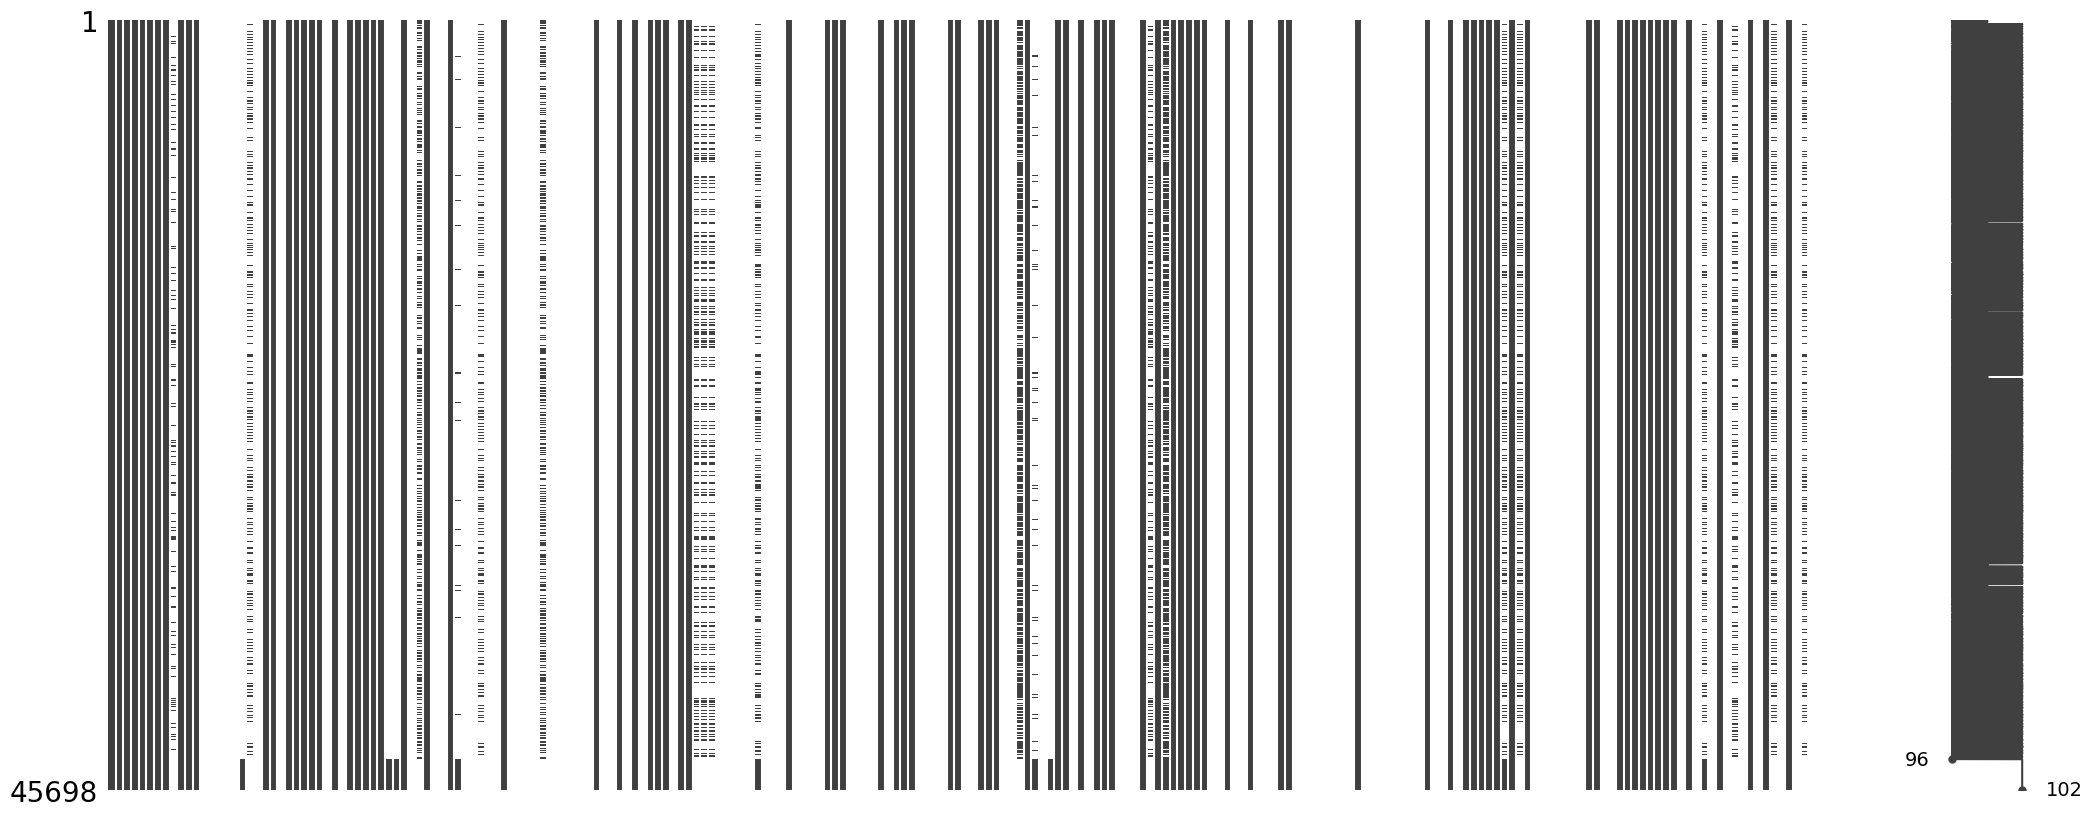

In [10]:
import missingno as msno
%matplotlib inline
msno.matrix(df_mb)

# Data Cleansing

## initial cleaning

In [11]:
df = df_mb.copy()

In [12]:
# Spalten die nur NAN enthalten entfernen
df = df.dropna(axis=1, how='all')

# Spalten die ausschließlich XY Werte enthalten (0 / X / 1 / etc.) dropen
df = df.loc[:, (df.astype(str) != 0).any(axis=0)]
df = df.loc[:, (df.astype(str) != '0,0').any(axis=0)]
df = df.loc[:, (df.astype(str) != '0,00').any(axis=0)]
df = df.loc[:, (df.astype(str) != '0,000').any(axis=0)]
df = df.loc[:, (df.astype(str) != 'X').any(axis=0)]
df = df.loc[:, (df.astype(str) != '1').any(axis=0)]

#spaletn entfernen die immer die selben Werte enthalten
keep_columns = [col for col in df.columns if len(df[col].unique()) > 1]
df = df[keep_columns].copy()


#print(len(df_io.index))
df.shape

(45698, 71)

<Axes: >

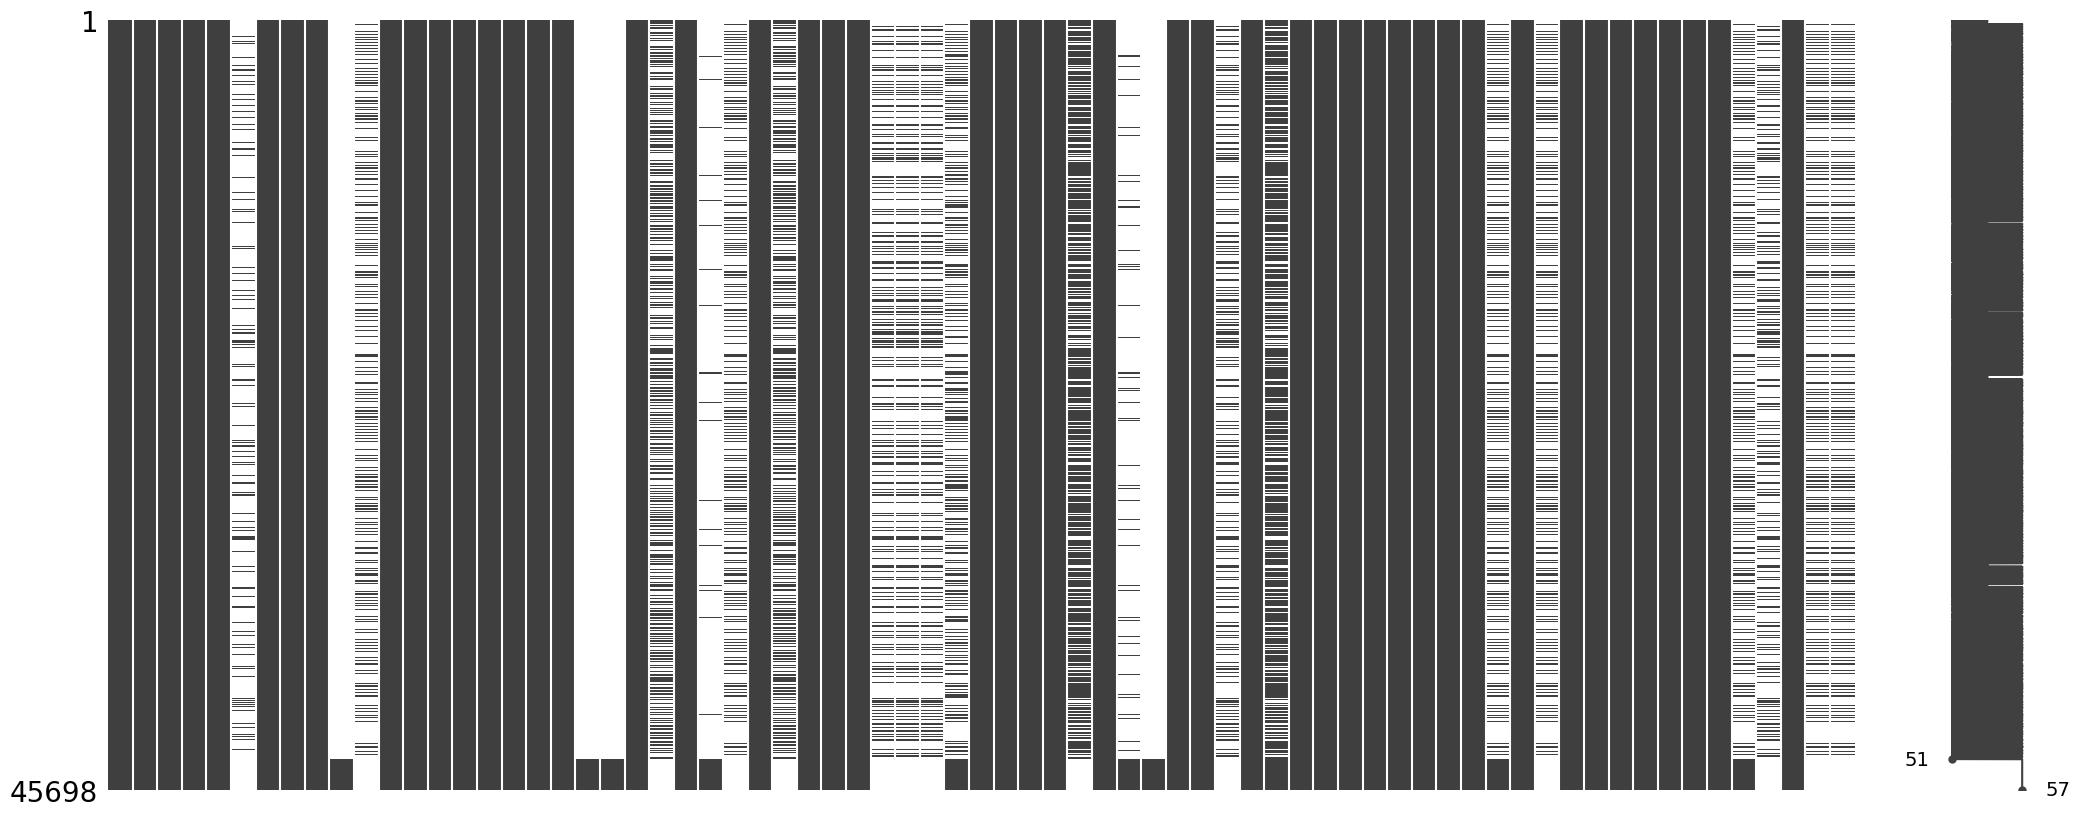

In [13]:
import missingno as msno
%matplotlib inline
msno.matrix(df)

In [14]:
df.head(4)

,MBLNR,ZEILE,LINE_ID,PARENT_ID,BWART,XAUTO,MATNR,WERKS,LGORT,LIFNR,KUNNR,SHKZG,DMBTR,BUALT,MENGE,MEINS,ERFMG,ERFME,BPMNG,BPRME,EBELN,EBELP,LFBNR,LFPOS,ELIKZ,WEMPF,KOKRS,AUFNR,BUKRS,RSNUM,RSPOS,UMMAT,UMWRK,UMLGO,KZBEW,WEANZ,PRCTR,AUFPL,AUFPS,SAKTO,BSTMG,BSTME,EMLIF,PPRCTR,MATBF,UMMAB,BUSTM,BUSTW,LBKUM,SALK3,VPRSV,URZEI,VGART_MKPF,BUDAT_MKPF,CPUDT_MKPF,CPUTM_MKPF,XBLNR_MKPF,TCODE2_MKPF,VBELN_IM,VBELP_IM,VGART,BLART,BLDAT,BUDAT,CPUDT,CPUTM,XBLNR,WEVER,TCODE2,BFWMS,LE_VBELN
0,4900000000,1,1,0,101,NaN,GG-F11,GG,02,NaN,NaN,S,38640.0,38640.0,24000.0,ST,24000.0,ST,0,NaN,NaN,0,1.0,6,NaN,NaN,GG,1000028.0,GG,0,0,NaN,NaN,NaN,F,1,GG,29,1,895000.0,24000,ST,NaN,GG,GG-F11,NaN,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,14:17:56,NaN,COGI,NaN,0,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,NaN,COGI,NaN,NaN
1,4900000001,1,1,0,101,NaN,II-F13,II,02,NaN,NaN,S,57980.0,57980.0,26000.0,ST,26000.0,ST,0,NaN,NaN,0,2.0,6,NaN,NaN,II,1000000.0,II,0,0,NaN,NaN,NaN,F,1,II,1,1,895000.0,26000,ST,NaN,II,II-F13,NaN,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,14:17:56,NaN,COGI,NaN,0,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,NaN,COGI,NaN,NaN
2,4900000002,1,1,0,101,NaN,CC-F06,CC,02,NaN,NaN,S,39550.0,39550.0,35000.0,ST,35000.0,ST,0,NaN,NaN,0,3.0,9,X,NaN,CC,1000009.0,CC,0,0,NaN,NaN,NaN,F,1,CC,10,1,895000.0,35000,ST,NaN,CC,CC-F06,NaN,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,14:17:56,NaN,COGI,NaN,0,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,NaN,COGI,NaN,NaN
3,4900000003,1,1,0,101,NaN,EE-F02,EE,02,NaN,NaN,S,30240.0,30240.0,24000.0,ST,24000.0,ST,0,NaN,NaN,0,4.0,6,NaN,NaN,EE,1000005.0,EE,0,0,NaN,NaN,NaN,F,1,EE,6,1,895000.0,24000,ST,NaN,EE,EE-F02,NaN,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,14:17:56,NaN,COGI,NaN,0,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,NaN,COGI,NaN,NaN


In [16]:
# have lost somhow pretty much of the data due to the sparcity and empty cols

In [15]:
#lets add the time and date column
#CPUDT_MKPF 	CPUTM_MKPF
df['CPUDT'] = df_mb['CPUDT_MKPF']

#as Timestamp
#df['TMSTMP'] = pd.to_datetime(df['CPUTM'].astype(str)+' '+df['CPUDT'].astype(str))
df['TMSTMP'] = pd.to_datetime(df['CPUDT'].astype(str) + df['CPUTM'].astype(str) , format='%Y-%m-%d%H:%M:%S')

In [16]:
df.head(4)

,MBLNR,ZEILE,LINE_ID,PARENT_ID,BWART,XAUTO,MATNR,WERKS,LGORT,LIFNR,KUNNR,SHKZG,DMBTR,BUALT,MENGE,MEINS,ERFMG,ERFME,BPMNG,BPRME,EBELN,EBELP,LFBNR,LFPOS,ELIKZ,WEMPF,KOKRS,AUFNR,BUKRS,RSNUM,RSPOS,UMMAT,UMWRK,UMLGO,KZBEW,WEANZ,PRCTR,AUFPL,AUFPS,SAKTO,BSTMG,BSTME,EMLIF,PPRCTR,MATBF,UMMAB,BUSTM,BUSTW,LBKUM,SALK3,VPRSV,URZEI,VGART_MKPF,BUDAT_MKPF,CPUDT_MKPF,CPUTM_MKPF,XBLNR_MKPF,TCODE2_MKPF,VBELN_IM,VBELP_IM,VGART,BLART,BLDAT,BUDAT,CPUDT,CPUTM,XBLNR,WEVER,TCODE2,BFWMS,LE_VBELN,TMSTMP
0,4900000000,1,1,0,101,NaN,GG-F11,GG,02,NaN,NaN,S,38640.0,38640.0,24000.0,ST,24000.0,ST,0,NaN,NaN,0,1.0,6,NaN,NaN,GG,1000028.0,GG,0,0,NaN,NaN,NaN,F,1,GG,29,1,895000.0,24000,ST,NaN,GG,GG-F11,NaN,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,14:17:56,NaN,COGI,NaN,0,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,NaN,COGI,NaN,NaN,2021-01-25 14:17:56
1,4900000001,1,1,0,101,NaN,II-F13,II,02,NaN,NaN,S,57980.0,57980.0,26000.0,ST,26000.0,ST,0,NaN,NaN,0,2.0,6,NaN,NaN,II,1000000.0,II,0,0,NaN,NaN,NaN,F,1,II,1,1,895000.0,26000,ST,NaN,II,II-F13,NaN,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,14:17:56,NaN,COGI,NaN,0,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,NaN,COGI,NaN,NaN,2021-01-25 14:17:56
2,4900000002,1,1,0,101,NaN,CC-F06,CC,02,NaN,NaN,S,39550.0,39550.0,35000.0,ST,35000.0,ST,0,NaN,NaN,0,3.0,9,X,NaN,CC,1000009.0,CC,0,0,NaN,NaN,NaN,F,1,CC,10,1,895000.0,35000,ST,NaN,CC,CC-F06,NaN,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,14:17:56,NaN,COGI,NaN,0,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,NaN,COGI,NaN,NaN,2021-01-25 14:17:56
3,4900000003,1,1,0,101,NaN,EE-F02,EE,02,NaN,NaN,S,30240.0,30240.0,24000.0,ST,24000.0,ST,0,NaN,NaN,0,4.0,6,NaN,NaN,EE,1000005.0,EE,0,0,NaN,NaN,NaN,F,1,EE,6,1,895000.0,24000,ST,NaN,EE,EE-F02,NaN,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,14:17:56,NaN,COGI,NaN,0,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,NaN,NaN,COGI,NaN,NaN,2021-01-25 14:17:56


In [17]:
#sanity check
df.shape

(45698, 72)

In [ ]:
# manual cleaning plant specifics

In [18]:
df.drop(['WERKS', 'KOKRS', 'BUKRS', 'PRCTR', 'PPRCTR'],axis=1, inplace=True)

In [19]:
df.MATBF = df.MATBF.str.slice(3)
df.MATNR = df.MATNR.str.slice(3)

In [ ]:
#2 Del
#ZEILE LINE_ID CPUTM_MKPF
df = df.drop(['CPUTM_MKPF'], axis=1)
df = df.drop(['ZEILE'], axis=1)
df = df.drop(['LINE_ID'], axis=1)


In [44]:
df = df.drop(['XBLNR_MKPF'], axis=1)
df = df.drop(['TCODE2_MKPF'], axis=1)

## data types correction

In [20]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
MBLNR,45698.0,NaN,NaN,NaN,4904006550.281106,4900000000.0,4900003527.0,4900006914.0,4900010288.0,5000000459.0,19595289.145887
ZEILE,45698.0,NaN,NaN,NaN,3.720819,1.0,1.0,3.0,5.0,32.0,3.489511
LINE_ID,45698.0,NaN,NaN,NaN,3.726137,1.0,1.0,3.0,5.0,32.0,3.489146
PARENT_ID,45698.0,NaN,NaN,NaN,0.468795,0.0,0.0,0.0,0.0,16.0,1.522371
BWART,45698.0,NaN,NaN,NaN,344.790538,101.0,261.0,301.0,601.0,601.0,164.945653
XAUTO,5690,1,X,5690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MATNR,45698,22,F11,4413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LGORT,45698,5,88,18892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LIFNR,1828,2,V01,1228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KUNNR,12269.0,NaN,NaN,NaN,80156.527834,80100.0,80121.0,80146.0,80168.0,80293.0,47.637028


In [21]:
df.sample(10)

,MBLNR,ZEILE,LINE_ID,PARENT_ID,BWART,XAUTO,MATNR,LGORT,LIFNR,KUNNR,SHKZG,DMBTR,BUALT,MENGE,MEINS,ERFMG,ERFME,BPMNG,BPRME,EBELN,EBELP,LFBNR,LFPOS,ELIKZ,WEMPF,AUFNR,RSNUM,RSPOS,UMMAT,UMWRK,UMLGO,KZBEW,WEANZ,AUFPL,AUFPS,SAKTO,BSTMG,BSTME,EMLIF,MATBF,UMMAB,BUSTM,BUSTW,LBKUM,SALK3,VPRSV,URZEI,VGART_MKPF,BUDAT_MKPF,CPUDT_MKPF,CPUTM_MKPF,XBLNR_MKPF,TCODE2_MKPF,VBELN_IM,VBELP_IM,VGART,BLART,BLDAT,BUDAT,CPUDT,CPUTM,XBLNR,WEVER,TCODE2,BFWMS,LE_VBELN,TMSTMP
25044,4900007579,4,4,0,261,NaN,R05,88,NaN,NaN,H,10670.01,0.00,8400.0,KG,8400.0,KG,0,NaN,NaN,0,1807.0,2,NaN,NaN,1000703.0,1783,2,NaN,NaN,NaN,NaN,0,704,0,400000.0,0,NaN,NaN,R05,NaN,MA01,WA01,58800.0,74690.08,V,4,WR,2021-02-01,2021-02-01,14:51:34,NaN,COGI,NaN,0,WR,WA,2021-02-01,2021-02-01,2021-02-01,14:51:34,NaN,NaN,COGI,NaN,NaN,2021-02-01 14:51:34
41935,4900012581,2,2,0,601,NaN,F13,02S,NaN,80140.0,H,8915.54,8915.54,3998.0,ST,3998.0,ST,0,NaN,NaN,0,NaN,0,NaN,80140.0,NaN,0,0,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,F13,NaN,MA01,WA01,51521.0,114891.83,S,2,WL,2021-02-04,2021-02-04,15:33:03,80005400.0,VL02N,80005400.0,20,WL,WL,2021-02-04,2021-02-04,2021-02-04,15:33:03,80005400.0,NaN,VL02N,2.0,80005400.0,2021-02-04 15:33:03
12668,4900003908,1,1,0,601,NaN,F12,02W,NaN,80155.0,H,6926.64,6926.64,3534.0,ST,3534.0,ST,0,NaN,NaN,0,NaN,0,NaN,80155.0,NaN,0,0,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,F12,NaN,MA01,WA01,43162.0,84597.52,S,1,WL,2021-01-28,2021-01-28,14:33:43,80001704.0,VL02N,80001704.0,10,WL,WL,2021-01-28,2021-01-28,2021-01-28,14:33:43,80001704.0,NaN,VL02N,2.0,80001704.0,2021-01-28 14:33:43
29348,4900008855,1,1,0,101,NaN,F02,02,NaN,NaN,S,20160.00,20160.00,16000.0,ST,16000.0,ST,0,NaN,NaN,0,2115.0,6,X,NaN,1000797.0,0,0,NaN,NaN,NaN,F,1,798,1,895000.0,16000,ST,NaN,F02,NaN,MF01,WF01,59942.0,75526.92,S,1,WR,2021-02-01,2021-02-01,15:25:39,NaN,COGI,NaN,0,WR,WA,2021-02-01,2021-02-01,2021-02-01,15:25:39,NaN,NaN,COGI,NaN,NaN,2021-02-01 15:25:39
15670,4900004806,4,4,0,601,NaN,F02,02N,NaN,80146.0,H,5206.95,5206.95,3857.0,ST,3857.0,ST,0,NaN,NaN,0,NaN,0,NaN,80146.0,NaN,0,0,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,F02,NaN,MA01,WA01,41253.0,55691.55,S,4,WL,2021-01-28,2021-01-28,15:03:49,80002069.0,VL02N,80002069.0,40,WL,WL,2021-01-28,2021-01-28,2021-01-28,15:03:49,80002069.0,NaN,VL02N,2.0,80002069.0,2021-01-28 15:03:49
19491,4900005912,1,1,0,101,NaN,F14,02,NaN,NaN,S,55200.00,55200.00,40000.0,ST,40000.0,ST,0,NaN,NaN,0,1421.0,6,NaN,NaN,1000549.0,0,0,NaN,NaN,NaN,F,1,550,1,895000.0,40000,ST,NaN,F14,NaN,MF01,WF01,32030.0,44201.40,S,1,WR,2021-01-28,2021-01-28,15:34:29,NaN,COGI,NaN,0,WR,WA,2021-01-28,2021-01-28,2021-01-28,15:34:29,NaN,NaN,COGI,NaN,NaN,2021-01-28 15:34:29
22766,4900006893,1,1,0,601,NaN,F03,02S,NaN,80115.0,H,5700.39,5700.39,4101.0,ST,4101.0,ST,0,NaN,NaN,0,NaN,0,NaN,80115.0,NaN,0,0,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,F03,NaN,MA01,WA01,110675.0,153838.25,S,1,WL,2021-02-01,2021-02-01,14:25:36,80002951.0,VL02N,80002951.0,10,WL,WL,2021-02-01,2021-02-01,2021-02-01,14:25:36,80002951.0,NaN,VL02N,2.0,80002951.0,2021-02-01 14:25:36
13356,4900004114,1,1,0,101,NaN,F11,02,NaN,NaN,S,43470.00,43470.00,27000.0,ST,27000.0,ST,0,NaN,NaN,0,976.0,6,NaN,NaN,1000350.0,0,0,NaN,NaN,NaN,F,1,351,1,895000.0,27000,ST,NaN,F11,NaN,MF01,WF01,45441.0,73160.01,S,1,WR,2021-01-28,2021-01-28,14:38:36,NaN,COGI,NaN,0,WR,WA,2021-01-28,2021-01-28,2021-01-28,14:38:36,NaN,NaN,COGI,NaN,NaN,2021-01-28 14:38:36
26306,4900007964,1,1,0,261,NaN,P01,88,NaN,NaN,H,8387.42,0.00,24911.0,ST,24911.0,ST,0,NaN,NaN,0,1896.0,4,NaN,NaN,1000700.0,1754,4,NaN,NaN,NaN,NaN,0,701,0,400000.0,0,NaN,NaN,P01,NaN,MA01,WA01,168009.0,56567.89,V,1,WR,2021-02-01,2021-02-01,15:00:41,NaN,COGI,NaN,0,WR,WA,2021-02-01,2021-02-01,2021-02-01,15:00:41,NaN,NaN,COGI,NaN,NaN,2021-02-01 15:00:41
38403,4900011508,4,4,0,601,NaN,F11,02W,NaN,80156.0,H,9272.88,9272.88,5832.0,ST,5832.0,ST,0,NaN,NaN,0,NaN,0,NaN,80156.0,NaN,0,0,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,F11,NaN,MA01,WA01,59659.0,94857.81,S,4,WL,2021-02-04,2021-02-04,15:03:41,80004953.0,VL02N,80004953.0,40,WL,WL,2021-02-04,2021-02-04,2

In [32]:
cont_Cols = ['MBLNR', ]

#to many we create this list later by computation
cat_Cols = [ ]

num_Cols = ['DMBTR', 'BUALT', 'MENGE', 'ERFMG', 'BPMNG', 'LBKUM', 'SALK3', 'BSTMG'] #LSMNG

dat_Cols = ['CPUTM', 'CPUDT', 'TMSTMP', 'BUDAT', 'BLDAT', 'CPUDT_MKPF', 'BUDAT_MKPF']



In [33]:
list1 = df.columns.to_list()
print(list1)

#we already have these cols in num or cont or dat so lets make a list and remove them from all other than we have cat cols
unw = num_Cols + dat_Cols + cont_Cols

#cat cols are all cols - the cols we already defined as num / dat / cat
cat_Cols = [x for x in list1 if x not in unw]

['MBLNR', 'PARENT_ID', 'BWART', 'XAUTO', 'MATNR', 'LGORT', 'LIFNR', 'KUNNR', 'SHKZG', 'DMBTR', 'BUALT', 'MENGE', 'MEINS', 'ERFMG', 'ERFME', 'BPMNG', 'BPRME', 'EBELN', 'EBELP', 'LFBNR', 'LFPOS', 'ELIKZ', 'WEMPF', 'AUFNR', 'RSNUM', 'RSPOS', 'UMMAT', 'UMWRK', 'UMLGO', 'KZBEW', 'WEANZ', 'AUFPL', 'AUFPS', 'SAKTO', 'BSTMG', 'BSTME', 'EMLIF', 'MATBF', 'UMMAB', 'BUSTM', 'BUSTW', 'LBKUM', 'SALK3', 'VPRSV', 'URZEI', 'VGART_MKPF', 'BUDAT_MKPF', 'CPUDT_MKPF', 'XBLNR_MKPF', 'TCODE2_MKPF', 'VBELN_IM', 'VBELP_IM', 'VGART', 'BLART', 'BLDAT', 'BUDAT', 'CPUDT', 'CPUTM', 'XBLNR', 'WEVER', 'TCODE2', 'BFWMS', 'LE_VBELN', 'TMSTMP']


In [34]:
print(cat_Cols)

['PARENT_ID', 'BWART', 'XAUTO', 'MATNR', 'LGORT', 'LIFNR', 'KUNNR', 'SHKZG', 'MEINS', 'ERFME', 'BPRME', 'EBELN', 'EBELP', 'LFBNR', 'LFPOS', 'ELIKZ', 'WEMPF', 'AUFNR', 'RSNUM', 'RSPOS', 'UMMAT', 'UMWRK', 'UMLGO', 'KZBEW', 'WEANZ', 'AUFPL', 'AUFPS', 'SAKTO', 'BSTME', 'EMLIF', 'MATBF', 'UMMAB', 'BUSTM', 'BUSTW', 'VPRSV', 'URZEI', 'VGART_MKPF', 'XBLNR_MKPF', 'TCODE2_MKPF', 'VBELN_IM', 'VBELP_IM', 'VGART', 'BLART', 'XBLNR', 'WEVER', 'TCODE2', 'BFWMS', 'LE_VBELN']


In [35]:
#sanity check of cols
print(len(cont_Cols)+len(cat_Cols)+len(num_Cols)+len(dat_Cols))
print(df.shape[1]) 

64
64


In [36]:
# Change dtype to Category for relevant features
df_cor = df.copy()
df_cor.head()

# we have to change NaN top 0 to avoid the infer dtype "object" for some cols
#df_cor['ZUONR'] = df_cor['ZUONR'].fillna(0)


# change Dtype to Cat for categorical columns
cats_cat = df_cor[cat_Cols]
        
for (columnName, columnData) in cats_cat.items():
    df_cor[columnName] = df_cor[columnName].astype(str)
    if isinstance(df_cor[columnName][0], str):
        s = pd.Series(df_cor[columnName], dtype="category")
        df_cor[columnName] = df_cor[columnName].astype('category')



In [37]:
#check 1
df_cor.dtypes

MBLNR                   int64
PARENT_ID            category
BWART                category
XAUTO                category
MATNR                category
LGORT                category
LIFNR                category
KUNNR                category
SHKZG                category
DMBTR                 float64
BUALT                 float64
MENGE                 float64
MEINS                category
ERFMG                 float64
ERFME                category
BPMNG                   int64
BPRME                category
EBELN                category
EBELP                category
LFBNR                category
LFPOS                category
ELIKZ                category
WEMPF                category
AUFNR                category
RSNUM                category
RSPOS                category
UMMAT                category
UMWRK                category
UMLGO                category
KZBEW                category
WEANZ                category
AUFPL                category
AUFPS                category
SAKTO     

In [38]:
#check 2
print('Categorical columns: {}'.format(list(df_cor.select_dtypes('category').columns)))

Categorical columns: ['PARENT_ID', 'BWART', 'XAUTO', 'MATNR', 'LGORT', 'LIFNR', 'KUNNR', 'SHKZG', 'MEINS', 'ERFME', 'BPRME', 'EBELN', 'EBELP', 'LFBNR', 'LFPOS', 'ELIKZ', 'WEMPF', 'AUFNR', 'RSNUM', 'RSPOS', 'UMMAT', 'UMWRK', 'UMLGO', 'KZBEW', 'WEANZ', 'AUFPL', 'AUFPS', 'SAKTO', 'BSTME', 'EMLIF', 'MATBF', 'UMMAB', 'BUSTM', 'BUSTW', 'VPRSV', 'URZEI', 'VGART_MKPF', 'XBLNR_MKPF', 'TCODE2_MKPF', 'VBELN_IM', 'VBELP_IM', 'VGART', 'BLART', 'XBLNR', 'WEVER', 'TCODE2', 'BFWMS', 'LE_VBELN']


In [39]:
#check 3
df_cor.shape

(45698, 64)

<Axes: >

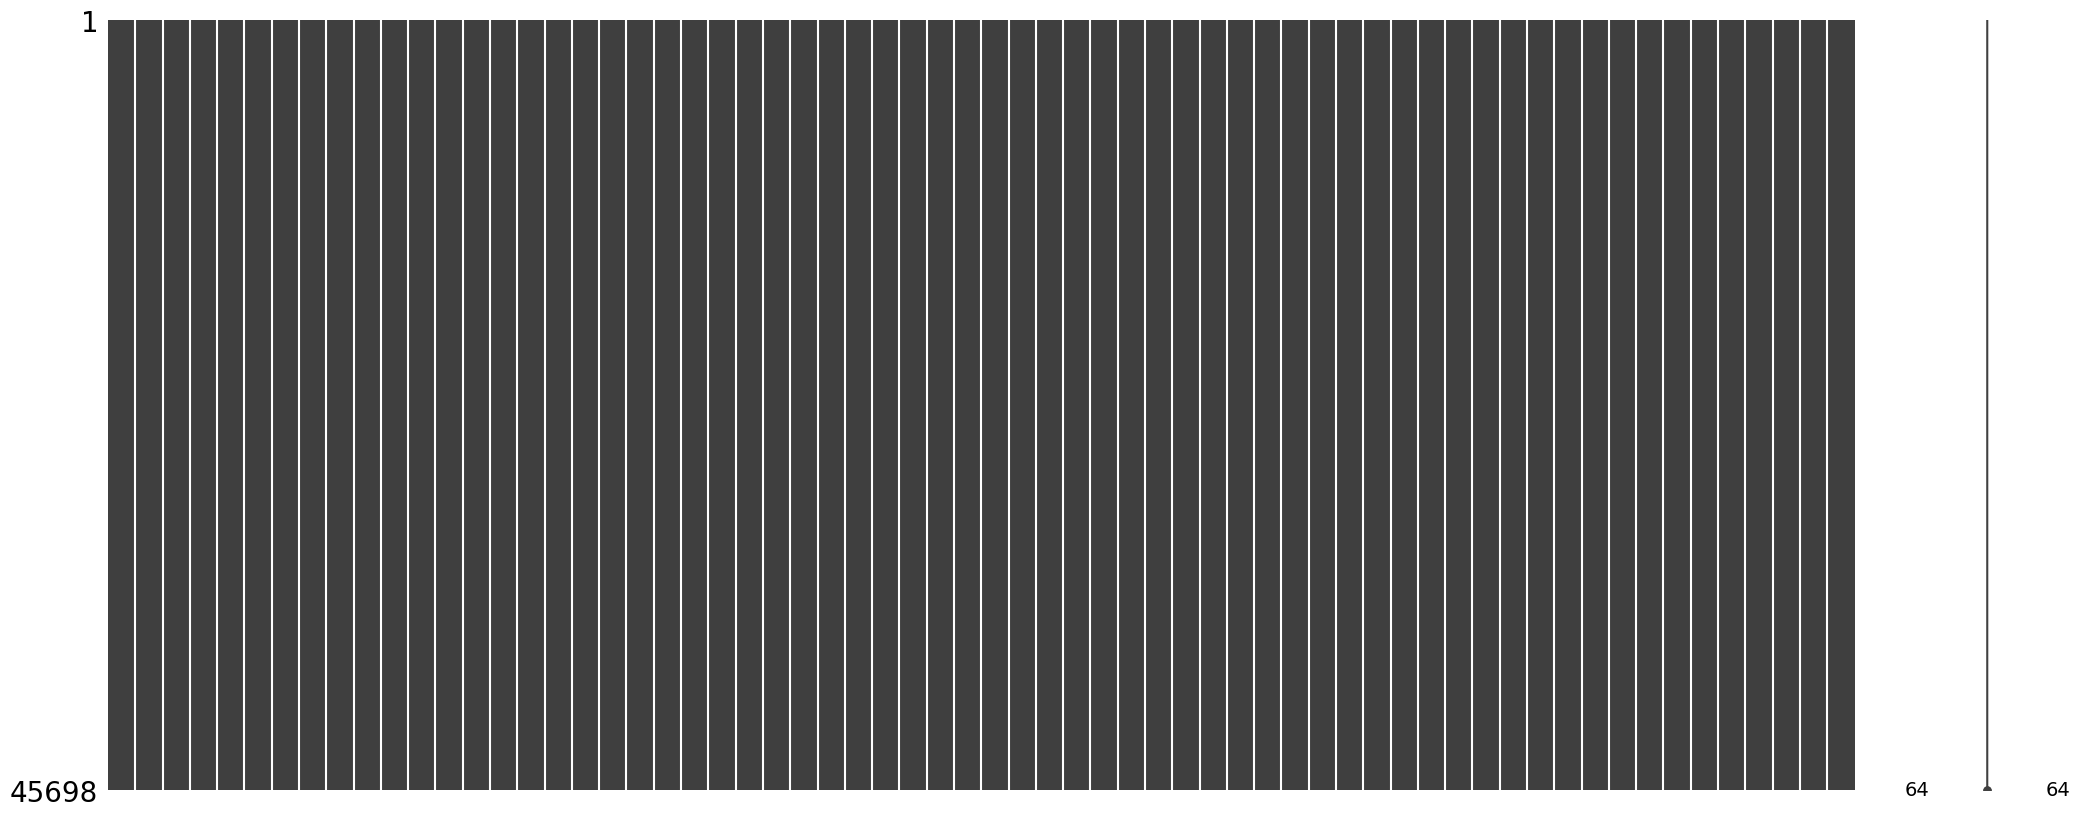

In [40]:
import missingno as msno
%matplotlib inline
msno.matrix(df_cor)

In [41]:
df_cor.to_feather('../Data/D3_MKPF-MSEG_raw.ftr')

# lets check the dataset properities / Correlation  / distribution

<Axes: >

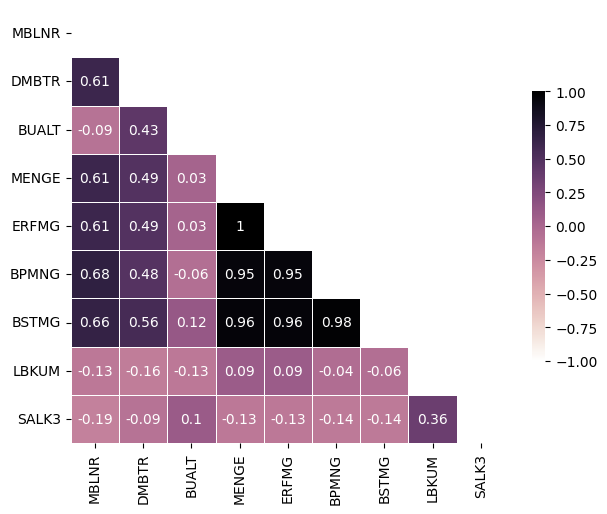

In [42]:
# Compute the corr matrix, only for numerics since we use category dtype
corr = df_cor.corr(numeric_only=True).round(2)

# Set up the triangular mask / matplotlib figure / Colors
mask = np.triu(np.ones_like(corr, dtype=bool)) # tril for upper
f, ax = plt.subplots(figsize=(7, 7))
cmap1 = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap1, vmax=1,vmin=-1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})


<Axes: >

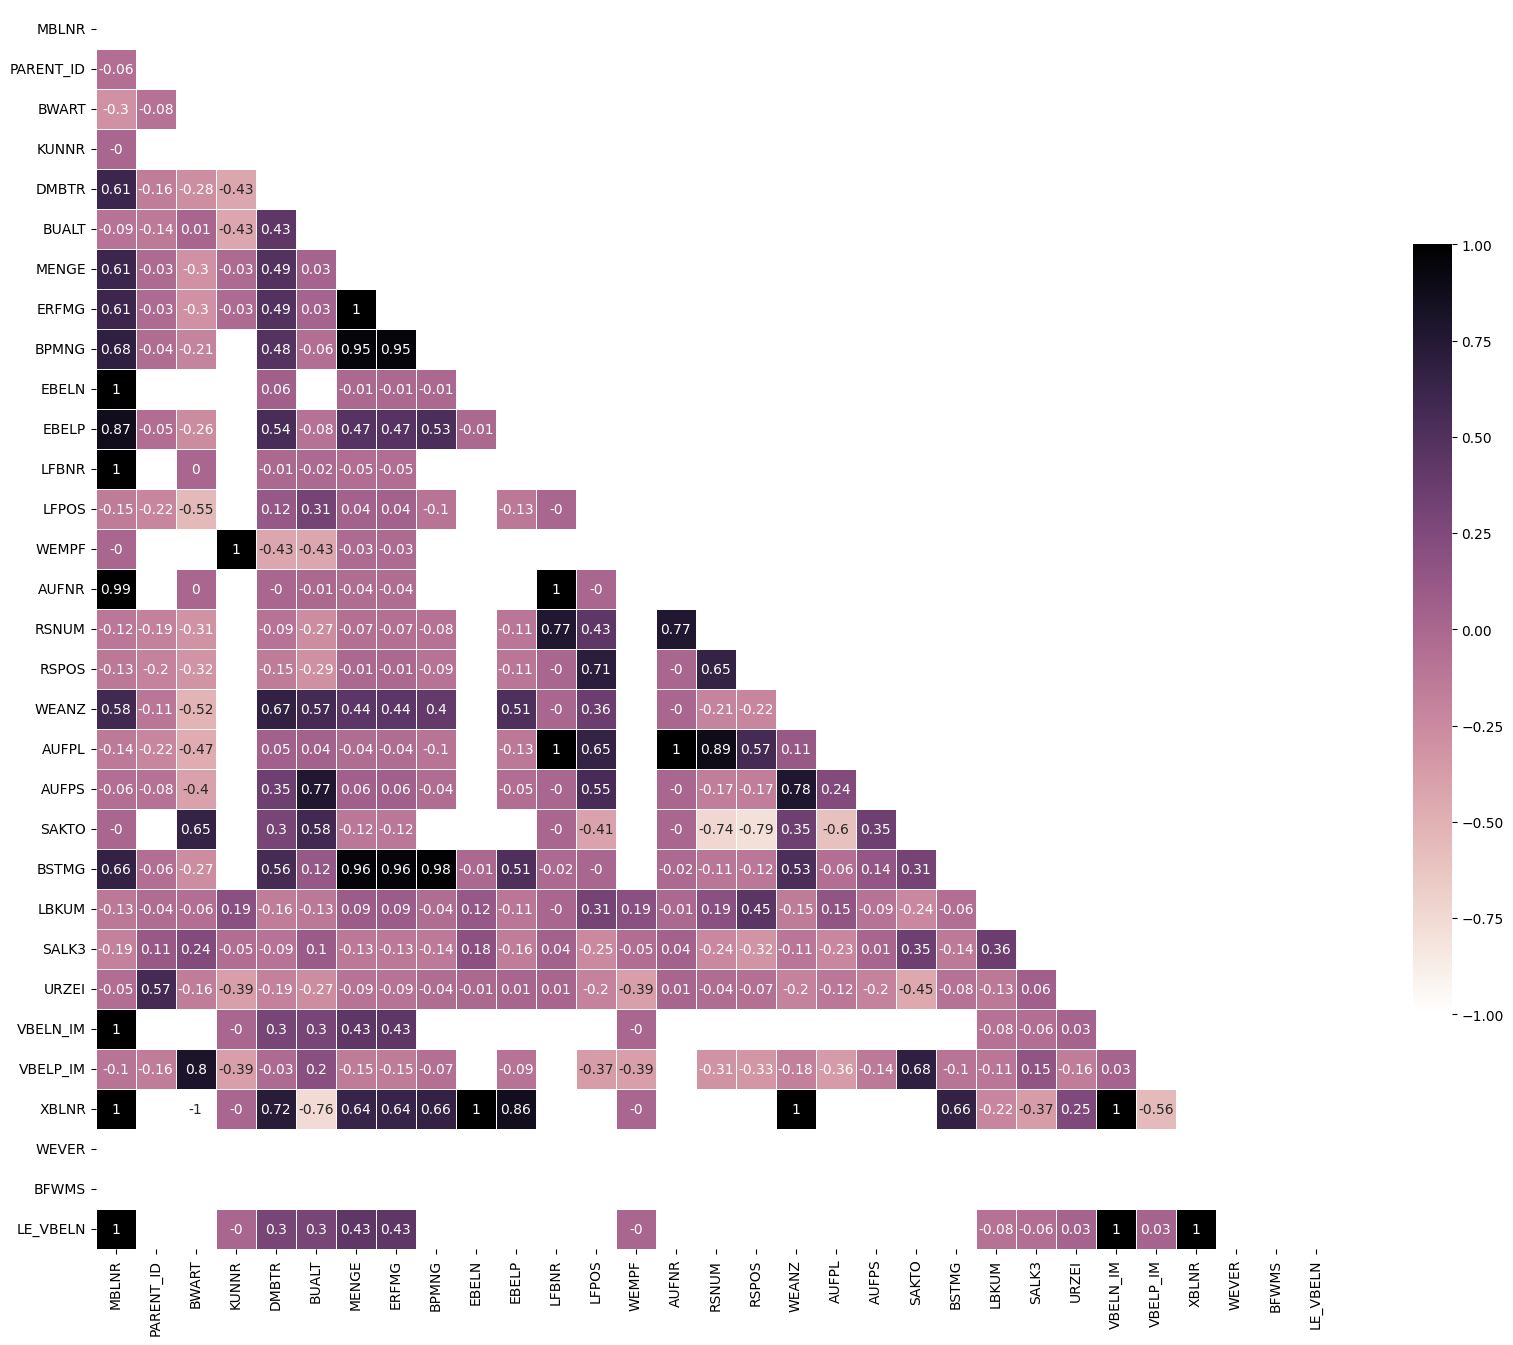

In [45]:

# Compute the corr matrix and 
corr = df.corr(numeric_only=True).round(2)

# Set up the triangular mask / matplotlib figure / Colors
mask = np.triu(np.ones_like(corr, dtype=bool)) # tril for upper
f, ax = plt.subplots(figsize=(20, 20))
cmap1 = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap1, vmax=1,vmin=-1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})


In [39]:
df.sample(10)

,MBLNR,PARENT_ID,BWART,XAUTO,MATNR,LGORT,INSMK,LIFNR,KUNNR,SHKZG,DMBTR,BUALT,MENGE,MEINS,ERFMG,ERFME,BPMNG,BPRME,EBELN,EBELP,LFBNR,LFPOS,ELIKZ,SGTXT,WEMPF,PROJN,AUFNR,RSNUM,RSPOS,KZSTR,UMMAT,UMWRK,UMLGO,KZBEW,WEANZ,AUFPL,AUFPS,SAKTO,BSTMG,BSTME,EMLIF,MATBF,UMMAB,BUSTM,BUSTW,LBKUM,SALK3,VPRSV,LSMNG,LSMEH,URZEI,ZUSTD_T156M,VGART_MKPF,USNAM_MKPF,XBLNR_MKPF,TCODE2_MKPF,VBELN_IM,VBELP_IM,VGART,BLART,CPUTM,USNAM,XBLNR,WEVER,TCODE2,BFWMS,LE_VBELN,CPUDT,TMSTMP
6458,4900002128,1,301,X,AA-F12,02N,NaN,NaN,NaN,S,0.00,0.00,10000,ST,10000,ST,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,2,AA-F12,AA,02,NaN,0,0,0,NaN,0,NaN,NaN,AA-F12,AA-F12,MA04,NaN,187230,423139.80,S,0,NaN,1,F,WA,ADMIN2,NaN,MB1B,NaN,0,WA,WA,17:12:06,ADMIN2,NaN,2.0,MB1B,NaN,NaN,2021-03-23,2021-03-23 17:12:06
2308,4900000768,0,261,NaN,AA-R05,88,NaN,NaN,NaN,H,8398.43,0.00,8400,KG,8400,KG,0,NaN,NaN,0,61.0,5,NaN,NaN,NaN,NaN,1000027.0,111,5,2,NaN,NaN,NaN,NaN,0,28,0,400000.0,0,NaN,NaN,AA-R05,NaN,MA01,WA01,35200,35193.40,V,0,NaN,7,F,WR,ADMIN2,NaN,COGI,NaN,0,WR,WA,14:56:43,ADMIN2,NaN,NaN,COGI,NaN,NaN,2021-03-23,2021-03-23 14:56:43
3708,4900001219,0,601,NaN,AA-F12,02N,NaN,NaN,80105.0,H,1003.44,1003.44,444,ST,444,ST,0,NaN,NaN,0,NaN,0,NaN,NaN,80105.0,NaN,NaN,0,0,2,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,AA-F12,NaN,MA01,WA01,314828,711511.28,S,0,NaN,2,F,WL,ADMIN2,80000994.0,VL02N,80000994.0,20,WL,WL,15:38:57,ADMIN2,80000994.0,NaN,VL02N,2.0,80000994.0,2021-03-23,2021-03-23 15:38:57
154,4900000052,0,601,NaN,AA-F12,02W,NaN,NaN,80162.0,H,1019.26,1019.26,451,ST,451,ST,0,NaN,NaN,0,NaN,0,NaN,NaN,80162.0,NaN,NaN,0,0,2,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,AA-F12,NaN,MA01,WA01,20646,46659.96,S,0,NaN,3,F,WL,ADMIN2,80000041.0,VL02N,80000041.0,30,WL,WL,11:35:40,ADMIN2,80000041.0,NaN,VL02N,2.0,80000041.0,2021-03-23,2021-03-23 11:35:40
7972,4900002663,0,601,NaN,AA-F16,02N,NaN,NaN,80134.0,H,876.75,876.75,525,ST,525,ST,0,NaN,NaN,0,NaN,0,NaN,NaN,80134.0,NaN,NaN,0,0,2,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,AA-F16,NaN,MA01,WA01,40654,67892.18,S,0,NaN,4,F,WL,ADMIN2,80002233.0,VL02N,80002233.0,40,WL,WL,17:49:47,ADMIN2,80002233.0,NaN,VL02N,2.0,80002233.0,2021-03-23,2021-03-23 17:49:47
8143,4900002723,0,601,NaN,AA-F12,02N,NaN,NaN,80167.0,H,1087.06,1087.06,481,ST,481,ST,0,NaN,NaN,0,NaN,0,NaN,NaN,80167.0,NaN,NaN,0,0,2,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,AA-F12,NaN,MA01,WA01,26052,58877.52,S,0,NaN,1,F,WL,ADMIN2,80002287.0,VL02N,80002287.0,10,WL,WL,17:51:37,ADMIN2,80002287.0,NaN,VL02N,2.0,80002287.0,2021-03-23,2021-03-23 17:51:37
694,4900000231,0,601,NaN,AA-F16,02S,NaN,NaN,80117.0,H,797.22,797.22,387,ST,387,ST,0,NaN,NaN,0,NaN,0,NaN,NaN,80117.0,NaN,NaN,0,0,2,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,AA-F16,NaN,MA01,WA01,64482,132832.92,S,0,NaN,1,F,WL,ADMIN2,80000183.0,VL02N,80000183.0,10,WL,WL,12:20:32,ADMIN2,80000183.0,NaN,VL02N,2.0,80000183.0,2021-03-23,2021-03-23 12:20:32
1874,4900000629,0,261,NaN,AA-P01,88,NaN,NaN,NaN,H,2240.00,0.00,8000,ST,8000,ST,0,NaN,NaN,0,51.0,7,NaN,NaN,NaN,NaN,1000022.0,92,7,2,NaN,NaN,NaN,NaN,0,23,0,400000.0,0,NaN,NaN,AA-P01,NaN,MA01,WA01,172000,48160.00,V,0,NaN,1,F,WR,ADMIN2,NaN,COGI,NaN,0,WR,WA,14:17:49,ADMIN2,NaN,NaN,COGI,NaN,NaN,2021-03-23,2021-03-23 14:17:49
4026,4900001322,0,601,NaN,AA-F12,02N,NaN,NaN,80105.0,H,1098.36,1098.36,486,ST,486,ST,0,NaN,NaN,0,NaN,0,NaN,NaN,80105.0,NaN,NaN,0,0,2,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,AA-F12,NaN,MA01,WA01,251787,569038.62,S,0,NaN,2,F,WL,ADMIN2,80001082.0,VL02N,80001082.0,20,WL,WL,15:47:10,ADMIN2,80001082.0,NaN,VL02N,2.0,80001082.0,2021-03-23,2021-03-23 15:47:10
8193,4900002740,0,601,NaN,AA-F12,02N,NaN,NaN,80129.0,H,1270.12,1270.12,562,ST,562,ST,0,NaN,NaN,0,NaN,0,NaN,NaN,80129.0,NaN,NaN,0,0,2,NaN,NaN,NaN,L,0,0,0,893010.0,0,NaN,NaN,AA-F12,NaN,MA01,WA01,9205,20803.30,S,0,NaN,2,F,WL,ADMIN2,80002304.0,VL02N,80002304.0,20,WL,WL,17:52:20,ADMIN2,80002304.0,NaN,VL02N,2.0,80002304.0,2021-03-23,2021-03-23 17:52:20


In [46]:
#manually delete the hihgly correlating features in both dataframes
# WRBTR PSWBT VBEL2 POSN2 ERFMG AUFPL SAKNR SAKNR LOKKT KIDNO
df_cor = df_cor.drop(['ERFMG'], axis=1)
df = df.drop(['ERFMG'], axis=1)

df_cor = df_cor.drop(['WEMPF'], axis=1)
df = df.drop(['WEMPF'], axis=1)

df_cor = df_cor.drop(['AUFPL'], axis=1)
df = df.drop(['AUFPL'], axis=1)



In [47]:
df_cor = df_cor.drop(['VBELP_IM'], axis=1)
df = df.drop(['VBELP_IM'], axis=1)

df_cor = df_cor.drop(['VBELN_IM'], axis=1)
df = df.drop(['VBELN_IM'], axis=1)

In [48]:
df_cor = df_cor.drop(['XBLNR'], axis=1)
df = df.drop(['XBLNR'], axis=1)

df_cor = df_cor.drop(['LE_VBELN'], axis=1)
df = df.drop(['LE_VBELN'], axis=1)

df_cor = df_cor.drop(['WEVER'], axis=1)
df = df.drop(['WEVER'], axis=1)


<Axes: >

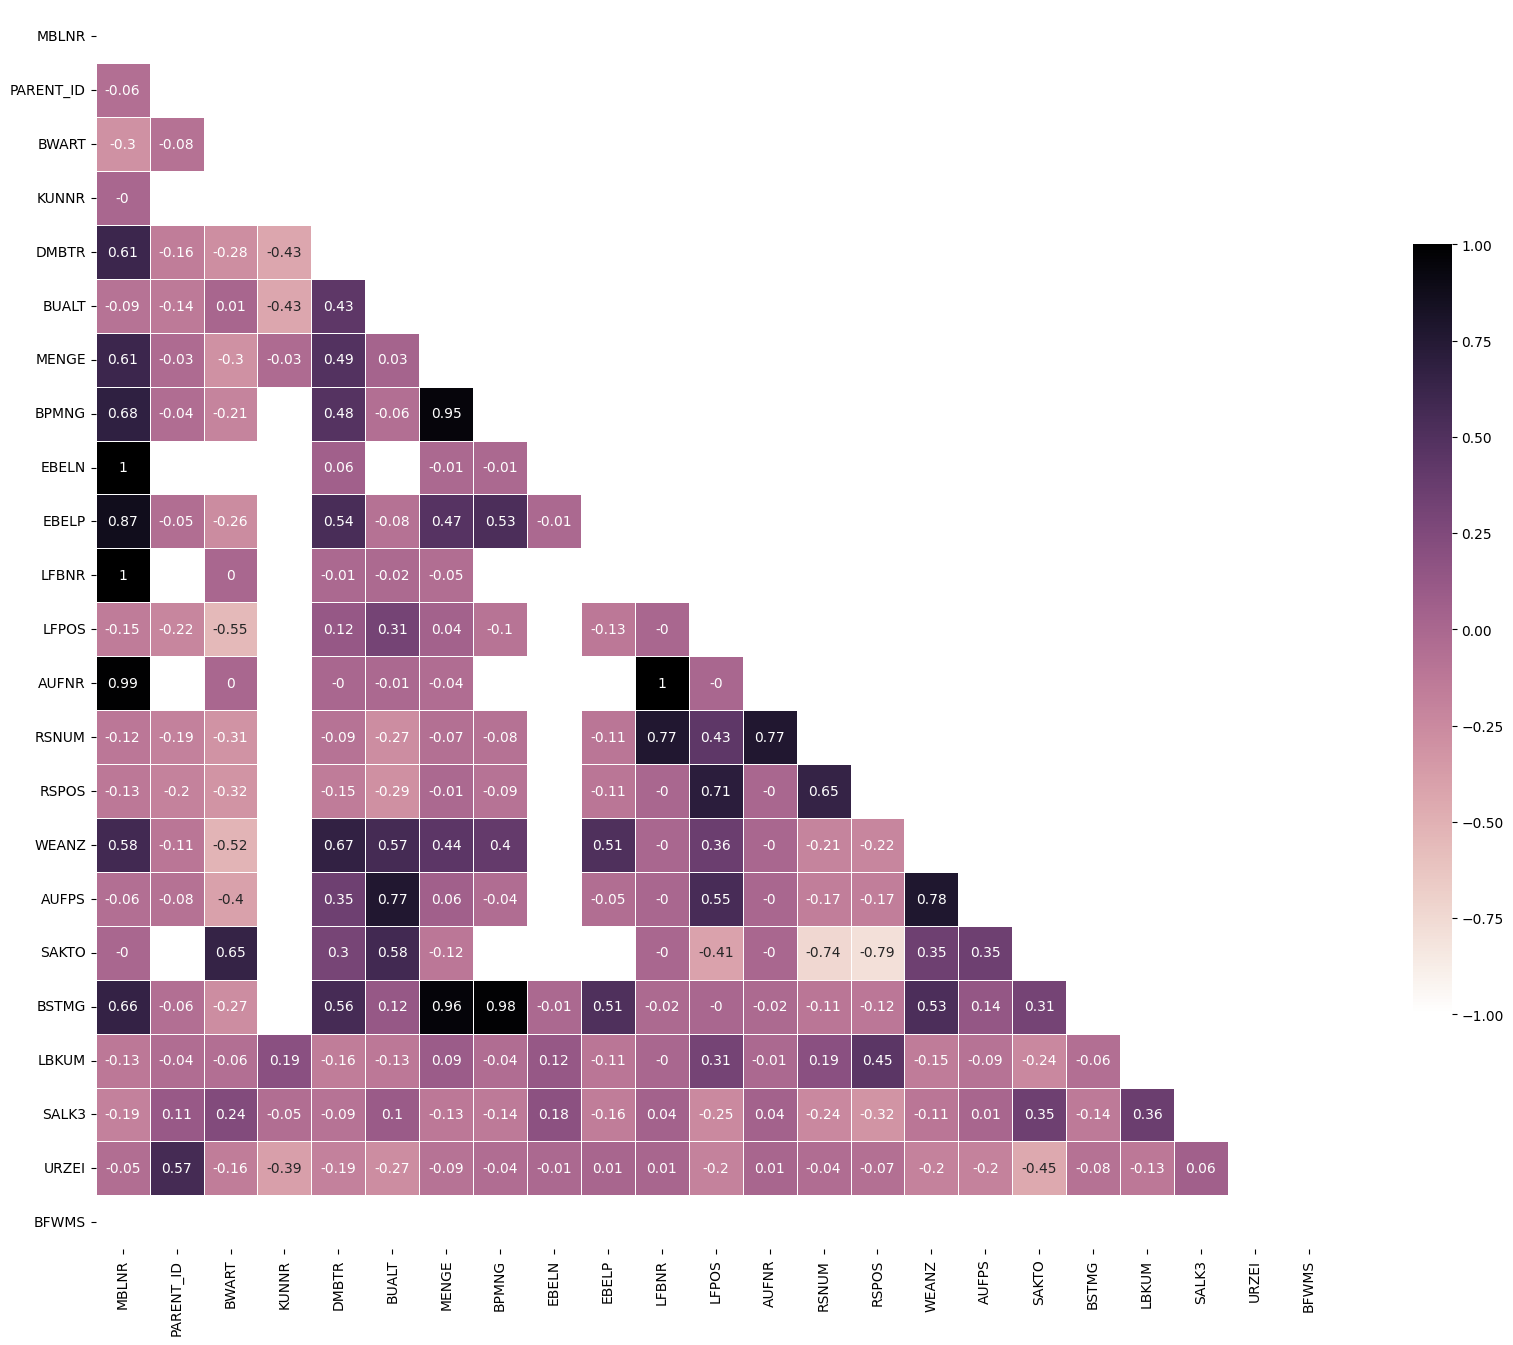

In [49]:
# Compute the corr matrix and 
corr = df.corr(numeric_only=True).round(2)

# Set up the triangular mask / matplotlib figure / Colors
mask = np.triu(np.ones_like(corr, dtype=bool)) # tril for upper
f, ax = plt.subplots(figsize=(20, 20))
cmap1 = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap1, vmax=1,vmin=-1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})


In [50]:
df_cor.head()

,MBLNR,PARENT_ID,BWART,XAUTO,MATNR,LGORT,LIFNR,KUNNR,SHKZG,DMBTR,BUALT,MENGE,MEINS,ERFME,BPMNG,BPRME,EBELN,EBELP,LFBNR,LFPOS,ELIKZ,AUFNR,RSNUM,RSPOS,UMMAT,UMWRK,UMLGO,KZBEW,WEANZ,AUFPS,SAKTO,BSTMG,BSTME,EMLIF,MATBF,UMMAB,BUSTM,BUSTW,LBKUM,SALK3,VPRSV,URZEI,VGART_MKPF,BUDAT_MKPF,CPUDT_MKPF,XBLNR_MKPF,TCODE2_MKPF,VGART,BLART,BLDAT,BUDAT,CPUDT,CPUTM,TCODE2,BFWMS,TMSTMP
0,4900000000,0,101,nan,F11,02,nan,nan,S,38640.0,38640.0,24000.0,ST,ST,0,nan,nan,0,1.0,6,nan,1000028.0,0,0,nan,nan,nan,F,1,1,895000.0,24000,ST,nan,F11,nan,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,nan,COGI,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,COGI,nan,2021-01-25 14:17:56
1,4900000001,0,101,nan,F13,02,nan,nan,S,57980.0,57980.0,26000.0,ST,ST,0,nan,nan,0,2.0,6,nan,1000000.0,0,0,nan,nan,nan,F,1,1,895000.0,26000,ST,nan,F13,nan,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,nan,COGI,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,COGI,nan,2021-01-25 14:17:56
2,4900000002,0,101,nan,F06,02,nan,nan,S,39550.0,39550.0,35000.0,ST,ST,0,nan,nan,0,3.0,9,X,1000009.0,0,0,nan,nan,nan,F,1,1,895000.0,35000,ST,nan,F06,nan,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,nan,COGI,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,COGI,nan,2021-01-25 14:17:56
3,4900000003,0,101,nan,F02,02,nan,nan,S,30240.0,30240.0,24000.0,ST,ST,0,nan,nan,0,4.0,6,nan,1000005.0,0,0,nan,nan,nan,F,1,1,895000.0,24000,ST,nan,F02,nan,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,nan,COGI,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:56,COGI,nan,2021-01-25 14:17:56
4,4900000004,0,101,nan,F06,02,nan,nan,S,30240.0,30240.0,24000.0,ST,ST,0,nan,nan,0,5.0,9,nan,1000001.0,0,0,nan,nan,nan,F,1,1,895000.0,24000,ST,nan,F06,nan,MF01,WF01,0.0,0.0,S,1,WR,2021-01-25,2021-01-25,nan,COGI,WR,WA,2021-01-25,2021-01-25,2021-01-25,14:17:57,COGI,nan,2021-01-25 14:17:57


In [51]:
df_cor.to_feather('../Data/D3_MKPF-MSEG_cleaned.ftr')